# Attaques adversariales

## Contexte

Il existe de nombreuses catégories d'attaques selon l'objectif de l'attaquant et ses connaissances. Cependant, en général, l'objectif principal est de trouver un compromis entre les perturbations ajoutées aux données pour provoquer un résultat eronné et l'imperceptibilité de ces perturbations. 

L'attaquant peut avoir deux type de connaissances :
<ul>
  <li><b>Boîte blanche </b>: une attaque en boîte blanche suppose que l'attaquant a une connaissance et un accès complets au modèle, y compris l'architecture, les entrées, les sorties et les poids. </li>
    <li><b>Boîte noire </b>: une attaque en boîte noire suppose que l'attaquant n'a accès qu'aux entrées et aux sorties du modèle, et ne connaît rien de l'architecture ou des poids sous-jacents.</li>
 </ul>

Il peut également avoir deux types d'objectifs :
<ul>
    <li><b>Mauvaise classification </b>: l'attaquant veut seulement que la classification de la sortie soit erronée mais ne se soucie pas de la nouvelle classification obtenue.
    <li><b>Mauvaise classification de la source/cible </b>: l'attaquant veut non seulement que la sortie soit erronée mais qu'elle soit également classée comme une classe cible spécifique.
</ul>

## Bibliographie

[1](https://arxiv.org/pdf/1412.6572v3.pdf) Goodfellow, I. J., Shlens, J., & Szegedy, C. (n.d.). EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES. Retrieved January 14, 2021

[2](https://arxiv.org/pdf/1607.02533.pdf) Kurakin, A., Brain, G., Openai, I. J. G., & Bengio, S. (2017). ADVERSARIAL EXAMPLES IN THE PHYSICAL WORLD.

[3](https://arxiv.org/pdf/1611.01236.pdf) Kurakin, A., Brain, G., Openai, I. J. G., & Bengio, S. (n.d.). ADVERSARIAL MACHINE LEARNING AT SCALE.

## Librairies Python

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## Données
Pour entrainer nos modèles (et les attaquer) nous allons utiliser la base MNIST. Il s’agit d’une base de données de chiffres de 0 à 9 écrits à la main qui est devenue un test standard notamment pour constituer des benchmarks.
Nous allons procéder à une analyse rapide de cette base.

In [2]:
# MNIST : charger les données
# //!\\ il faut créer un dossier data dans le répertoire contenant ce notebook pour pouvoir télécharger les données
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))

Les données sont séparées en deux sets : un set d’entraînement qui nous servira à produire des modèles et un set de test qui servira à connaître les performances des modèles obtenus.


Vous pouvez à présent tester des attributs et fonctions utiles comme (.shape, .data, .targets, plt.imshow()) qui vous permettront entre autres de visualiser les images (et les targets correspondants), de voir que le set d’entrainement et de test ont 60 000 et 10 000 images respectivement, que les images ont une taille de (1,28,28) (1 seul canal car les images sont en blanc et noir),...

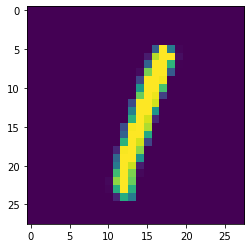

In [9]:
# A faire, explorer les données

## Modèle de classification

Nous pouvons utiliser un modèle pré-entraîné sur MNIST téléchargeable [ici](https://github.com/tobiascz/MNIST_Pytorch_python_and_capi/blob/master/model.pth).

Pour charger ce modèle, nous devons quand même créer une classe qui ait la même architecture que le modèle pré-entraîné. L’architecture à suivre est la suivante. 

In [2]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
# Créer et charger le modèle
model = Net()
model = torch.load('model.pth', map_location=torch.device('cpu'))
# Mettre le modèle en mode d'évaluation (effet sur certains type de couches comme Dropout, BatchNorm)
model.eval()

C:\Users\FE264791\Anaconda3\lib\site-packages\torch\serialization.py:752: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
C:\Users\FE264791\Anaconda3\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\FE264791\Anaconda3\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg,

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Hyperparamètres

Lorsque l'on utilise des réseaux de neurones ce sont souvent les hyperparamètres (par exemple le taux d'apprentissage, le momentum, la taille des batchs, ...) de ce modèle que l'on cherche à optimiser pour améliorer les performances. Nous ne nous attarderons pas sur cette partie dans notre cas car nous avons déjà un modèle entraîné, mais pour attaquer le réseau nous devons quand même définir certains paramètres, notamment :
<ul>
    <li>Taille de batchs de 32 (tombe bien car nous avons 32x1875 images d'entraînement)
    <li>Fonction de perte : negative log likelihood loss (utilisée en classification)

In [5]:
# A completer
train_batch_size = 32
loss_function = F.nll_loss

La mise en forme de nos données à l'état brut n'est pas adapté à notre réseau. Nous utilisons des fonctions de Pytorch qui permettent de le faire.

In [6]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=True)

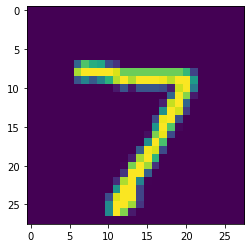

In [7]:
plt.imshow(testloader.dataset.data[0])

Regardons l'example d'une image :

In [8]:
im_example = torch.load('image_example.pt')

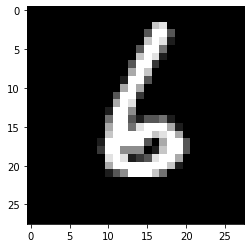

In [9]:
plt.imshow(im_example[0][0], cmap="gray") # plot de l'image

In [10]:
label_example = torch.LongTensor([6])

In [11]:
output = model(im_example) # sortie du réseau pour l'entrée de cette image
output, output.exp()

(tensor([[ -6.9752,  -6.3913,  -6.5515,  -8.7668,  -6.1040,  -4.6758,  -0.0249,
          -10.5114,  -4.7468,  -8.9781]], grad_fn=<LogSoftmaxBackward>),
 tensor([[9.3477e-04, 1.6760e-03, 1.4280e-03, 1.5582e-04, 2.2339e-03, 9.3178e-03,
          9.7542e-01, 2.7225e-05, 8.6796e-03, 1.2614e-04]],
        grad_fn=<ExpBackward>))

In [12]:
loss_function(output, label_example), torch.max(output.data, 1)[1] # fonction de perte et prédiction pour cette image

(tensor(0.0249, grad_fn=<NllLossBackward>), tensor([6]))

In [13]:
l = loss_function(model(im_example), label_example)

In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.grad)

conv1.weight torch.Size([10, 1, 5, 5]) None
conv1.bias torch.Size([10]) None
conv2.weight torch.Size([20, 10, 5, 5]) None
conv2.bias torch.Size([20]) None
fc1.weight torch.Size([50, 320]) None
fc1.bias torch.Size([50]) None
fc2.weight torch.Size([10, 50]) None
fc2.bias torch.Size([10]) None


In [23]:
l.backward()

In [26]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.grad)

conv1.weight torch.Size([10, 1, 5, 5]) tensor([[[[-2.3637e-03, -1.4875e-04,  3.5476e-03,  1.5285e-03,  4.8737e-04],
          [-3.1111e-03,  1.1636e-03,  3.6912e-03,  1.5787e-03,  3.1496e-03],
          [-3.9137e-03,  3.9039e-04, -5.1546e-04,  1.3545e-03,  1.3734e-02],
          [ 7.4280e-04,  2.2398e-03,  6.8025e-04,  4.8857e-03,  2.1181e-02],
          [ 5.4558e-03,  6.0241e-03,  4.6312e-03,  1.2922e-02,  2.4157e-02]]],


        [[[-2.0573e-03, -8.4778e-03, -1.4845e-02, -9.0448e-03, -3.3225e-03],
          [-5.7659e-03, -1.3188e-02, -1.3347e-02, -7.1729e-03, -2.2163e-03],
          [-1.3483e-02, -1.8040e-02, -1.1322e-02, -3.6638e-03, -2.6184e-03],
          [-1.7003e-02, -1.5935e-02, -9.9794e-03, -4.1903e-03, -3.8969e-03],
          [-1.5483e-02, -1.0090e-02, -6.0787e-03, -5.3805e-03, -5.8067e-03]]],


        [[[-7.3011e-04, -1.6185e-04, -9.8990e-03, -1.5031e-02, -1.0345e-02],
          [-3.7698e-03, -6.8445e-03, -1.8765e-02, -1.8706e-02, -7.5507e-03],
          [-6.9866e-03, -1.85

Regardons maintenant la précision gloable du modèle :

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


## Attaques adversariales

2 types d'attaques seront abordées :
<ul>
    <li> Fast Gradient Sign Method (FGSM)</li>
    <li> Least-likely class method</li>
</ul>

### Fast Gradient Sign Method (FGSM)

Tout d'abord, nous allons implémenter l'attaque FGSM. Il s'agit d'une attaque de type boîte blanche ayant pour but une mauvaise classification. C'est une methode simple à implementer mais qui permet quand même de perturber des réseaux assez efficacement. On s'inspire de l'algorithme de descente de gradient pour perturber l'image pour chercher l'image qui <b>maximise</b> la fonction de perte. 

En effet, pour améliorer le réseau le but est de minimiser cette fonction de perte en soustrayant aux données d'entrée la dérivée de la fonction de perte par rapport à ces dernières. Ici, nous allons plutôt <b>ajouter</b> à l'image cette dérivée, dans le but de maximiser la fonction de perte grâce à l'équation (1) :
\begin{equation}
\label{eq:fgsm}
x_{noised} = x_{clean} + \epsilon sign(\nabla_x L(\hat{y}, y))
\end{equation}

Prenons notre exemple de tout à l'heure :

Sans perturber l'image, montrer que le réseau prédit correctement le label associé à l'image :

In [14]:
# A compléter
output = 
pred = 
print(pred)

tensor([6])

Nous voulons maintenant récupérer le gradient par rapport aux données d'entrée. 

In [26]:
# A compléter

# Important : l'attribut requires_grad du tensor des données doit être vrai pour pouvoir calculer
# le gradient de la fonction de perte par rapport à celui-ci


# Récupérer la sortie du modèle
output = 

# Calculer la fonction de perte
loss = 

# Important : mettre à zero tous les gradients du modèle car sinon ils seront accumulés


# Calcule les gradients de la fonction de perte lors de la retropropagation


# Récupérer les gradients par rapport aux données d'entrée
im_grad = 

C:\Users\FE264791\Anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Maintenant nous allons créer une fonction pour perturber l'image en utilisant la formule (1) :

In [33]:
# FGSM attack
def fgsm_attack_step(image, epsilon, grad):
    """
    image : donnée non bruitée
    epsilon : définit le taux de perturbation de l'image
    grad : tensor contenant les gradients de la fonction de perte par rapport à l'image
    """
    # A compléter
    
    # Récupérer le signe des coefficients data_grad
    sign_data_grad = 
    
    # Créer l'image bruitée à partir de l'image en entrée
    noised_image = 
    
    # Borner l'image obtenue entre 0 et 1 (utiliser torch.clamp)
    noised_image = torch.clamp(noised_image, 0, 1)
    
    # Retourner l'image bruitée
    return noised_image

Pour notre même exemple, observons l'image bruitée. Vous pouvez tester différentes valeurs d'$\epsilon$.

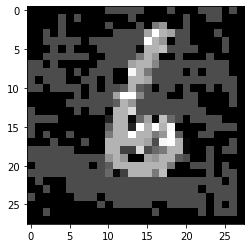

In [38]:
# Regardons le résultat de la perturbation
im_noised = fgsm_attack_step(im_example, 0.3, im_grad)
plt.imshow(im_noised.detach().numpy()[0][0], cmap='gray')

Nous remarquons qu'en augmentant la valeur d'$\epsilon$ l'image est quelque peu perturbée mais elle reste visible pour l'oeil humain. Mais est-ce le cas pour le réseau ?

In [39]:
# A compléter
output = 
pred = 
print(pred)

tensor([8])

### Least likely class method

Nous allons implémenter l'attaque Step Least Likely (l.l.), qui ressemble beaucoup à l'attaque précédente. Cette fois-ci, nous ne considérons plus la fonction de perte entre les données d'entrée et les vrais labels mais la fonction de perte entre les données d'entrée et le label le **moins probable**. On effectue cette fois une variante de *descente* de gradient, parce qu'on essaye de diriger l'image vers l'image la moins probable :

\begin{equation}
\label{eq:ll}
x_{noised} = x_{clean} - \epsilon sign(\nabla_x L(\hat{y}, y_{l.l}))
\end{equation}


Prenons notre exemple de toute à l'heure :

Récupérons le gradient recherché :

In [20]:
# A compléter

# Important : l'attribut requires_grad du tensor des données doit être vrai pour pouvoir calculer
# le gradient de la fonction de perte par rapport à celui-ci


# Récupérer la prédiction du modèle
output = 
llclass = 

# Calculer la fonction de perte entre les valeurs voulues
loss = 

# Important : mettre à zero tous les gradients du modèle car sinon ils seront accumulés


# Calcule les gradients de la fonction de perte lors de la retropropagation


# Récupérer les gradients par rapport aux données d'entrée
grad = 

In [21]:
# Least likely class attack
def llclass_attack_step(image, epsilon, grad):
    """
    image : donnée non bruitée
    epsilon : définit le taux de perturbation de l'image
    grad : tensor contenant le utilisé dans l'attaque
    """
    # Récupérer le signe des coefficients data_grad
    sign_data_grad = 
    
    # Créer l'image bruitée à partir de l'image en entrée
    noised_image = 
    
    # Borner l'image obtenue entre 0 et 1 (utiliser torch.clamp)
    noised_image = torch.clamp(noised_image, 0, 1)
    
    # Retourner l'image bruitée
    return noised_image

Pour notre même exemple, observons l'image bruitée. Vous pouvez tester différentes valeurs d'$\epsilon$.

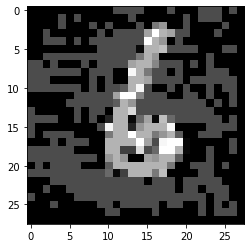

In [22]:
# Regardons le résultat de la perturbation
im_noised = llclass_attack_step(im_example, 0.3, im_grad)
plt.imshow(im_noised.detach().numpy()[0][0], cmap='gray')

Le réseau arrive-t-il à classifier l'image ?

In [23]:
# A compléter
output = 
pred =
print(pred)

tensor([8])

### Attaque du réseau
Nous allons maintenant attaquer le réseau entier avec ces deux méthodes et différentes valeurs d'$\epsilon$ pour voir comment la prédiction est dégradée. Nous allons attaquer uniquement les images classées correctement (si un exemple a été mal classé, pas la peine de l'attaquer). 

Commençons d'abord par l'attaque FGSM :

In [24]:
def fgsm_attack(model, test_loader, epsilon):

    # Variables qui vont nous permettre de stocker les résultats
    robust_examples = 0
    adversarial_examples = []

    # Parcourir les examples dans les données d'entraînnement
    for image, target in test_loader:
        
        # Important : l'attribut requires_grad du tensor des données doit être vrai pour pouvoir calculer
        # le gradient de la fonction de perte par rapport à celui-ci
        
        
        # Récupérer la prédiction du modèle
        output = 
        pred = 
        
        # Attaquer uniquement des classifications correctes
        if pred.item() == target.item():
            
            # Calculer la fonction de perte
            loss = 
            
            # Important : mettre à zero tous les gradients du modèle car sinon ils seront accumulés
            
            
            # Calcule les gradients de la fonction de perte lors de la retropropagation
            

            # Récupérer les gradients par rapport aux données d'entrée
            grad = 

            # Appeler la fonction d'attaque
            noised_data = fgsm_attack_step(image, epsilon, grad)
        
            # Re-classifier l'image bruitée et récupérer sa prédiction
            new_output = 
            attacked_pred = 

            # Stocker les exemples attaqués (robustes et vulnérables)
            if attacked_pred.item() == target.item():
                robust_examples += 1
            
            else :
                # Important : on stocke les examples pour pouvoir les visualiser par la suite.
                # Pour cela, les fonctions de python utilisent les données sous forme de numpy array. 
                # Pour calculer les gradients, ces données ont construit un graphe où le calcul des 
                # gradients a été stocké. Pour pouvoir utiliser les données sous format numpy, il faut
                # les "détacher" de ce graphe en appellant .detach() et ensuite .numpy() pour les 
                # convertir en numpy array.
                
                # Nous allons stocker que quelques exemples pour les visualiser:
                if len(adversarial_examples)<5:
                    adv_data = noised_data.squeeze().detach().numpy()
                    adversarial_examples += [(pred.item(), attacked_pred.item(), adv_data)]
                
    # Calculer la précision finale après l'attaque
    final_acc = robust_examples/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy with FGSM attack = {} / {} = {}".format(epsilon, robust_examples, len(test_loader), final_acc))

    # Retourner la précision finale et les examples adversariaux
    return final_acc, adversarial_examples

La fonction attaquant le réseau avec la méthode de la classe la moins probable sera similaire :

In [25]:
def llclass_attack(model, test_loader, epsilon):
    
    # Variables qui vont nous permettre de stocker les résultats
    robust_examples = 0
    adversarial_examples = []

    # Parcourir les examples dans les données d'entraînnement
    for image, target in test_loader:
        
        # Important : l'attribut requires_grad du tensor des données doit être vrai pour pouvoir calculer
        # le gradient de la fonction de perte par rapport à celui-ci
        
        
        # Récupérer la prédiction du modèle et la ll class
        output = 
        pred = 
        llclass = 

        # Attaquer uniquement des classifications correctes
        if pred.item() == target.item():
            
            # Calculer la fonction de perte
            loss = 
            
            # Important : mettre à zero tous les gradients du modèle car sinon ils seront accumulés
            
            
            # Calcule les gradients de la fonction de perte lors de la retropropagation
            

            # Récupérer les gradients par rapport aux données d'entrée
            grad = 
            
            # Appeler la fonction d'attaque
            noised_data = llclass_attack_step(image, epsilon, grad)
        
            # Re-classifier l'image bruitée et récupérer sa prédiction
            new_output = 
            attacked_pred = 

            # Stocker les examples attaqués (robustes et vulnérables)
            if attacked_pred.item() == target.item():
                robust_examples += 1
            
            else :
                # Important : on stocke les examples pour pouvoir les visualiser par la suite en général.
                # Pour cela, les fonctions de python utilisent les données sous forme de numpy array. 
                # Pour calculer les gradients, ces données ont construit un graphe où le calcul des 
                # gradients a été stocké. Pour pouvoir utiliser les données sous format numpy, il faut
                # les "détacher" de ce graphe en appellant .detach() et ensuite .numpy() pour les 
                # convertir en numpy array.
                
                # Nous allons stocker que quelques exemples pour les visualiser:
                if len(adversarial_examples)<5:
                    adv_data = noised_data.squeeze().detach().numpy()
                    adversarial_examples += [(pred.item(), attacked_pred.item(), adv_data)]
                
    # Calculer la précision finale après l'attaque
    final_acc = robust_examples/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy with ll class attack = {} / {} = {}".format(epsilon, robust_examples, len(test_loader), final_acc))
    
    # Retourner la précision finale et les examples adversariaux Return the accuracy and an adversarial example
    return final_acc, adversarial_examples

Nous allons maintenant attaquer les données test du réseau en utilisant différentes valeurs d'$\epsilon$ et stocker les résulats.

In [26]:
epsilons = [.05, .1, .15, .2, .25, .3]
accuracies_fgsm = {}
examples_fgsm = {}

accuracies_llclass = {}
examples_llclass = {}

# Tester différentes valeurs de epsilon
for eps in epsilons:
    print('---------Attack for epsilon {}---------'.format(eps))
    acc_fgsm, ex_fgsm = fgsm_attack(model, testloader, eps)
    acc_llclass, ex_llclass = llclass_attack(model, testloader, eps)
    
    accuracies_fgsm[eps], examples_fgsm[eps] = acc_fgsm, ex_fgsm
    accuracies_llclass[eps], examples_llclass[eps] = acc_llclass, ex_llclass

---------Attack for epsilon 0.05---------
Epsilon: 0.05	Test Accuracy with FGSM attack = 9401 / 10000 = 0.9401
Epsilon: 0.05	Test Accuracy with ll class attack = 9690 / 10000 = 0.969
---------Attack for epsilon 0.1---------
Epsilon: 0.1	Test Accuracy with FGSM attack = 8568 / 10000 = 0.8568
Epsilon: 0.1	Test Accuracy with ll class attack = 9319 / 10000 = 0.9319
---------Attack for epsilon 0.15---------
Epsilon: 0.15	Test Accuracy with FGSM attack = 7046 / 10000 = 0.7046
Epsilon: 0.15	Test Accuracy with ll class attack = 8326 / 10000 = 0.8326
---------Attack for epsilon 0.2---------
Epsilon: 0.2	Test Accuracy with FGSM attack = 4681 / 10000 = 0.4681
Epsilon: 0.2	Test Accuracy with ll class attack = 6363 / 10000 = 0.6363
---------Attack for epsilon 0.25---------
Epsilon: 0.25	Test Accuracy with FGSM attack = 2229 / 10000 = 0.2229
Epsilon: 0.25	Test Accuracy with ll class attack = 3811 / 10000 = 0.3811
---------Attack for epsilon 0.3---------
Epsilon: 0.3	Test Accuracy with FGSM attack = 

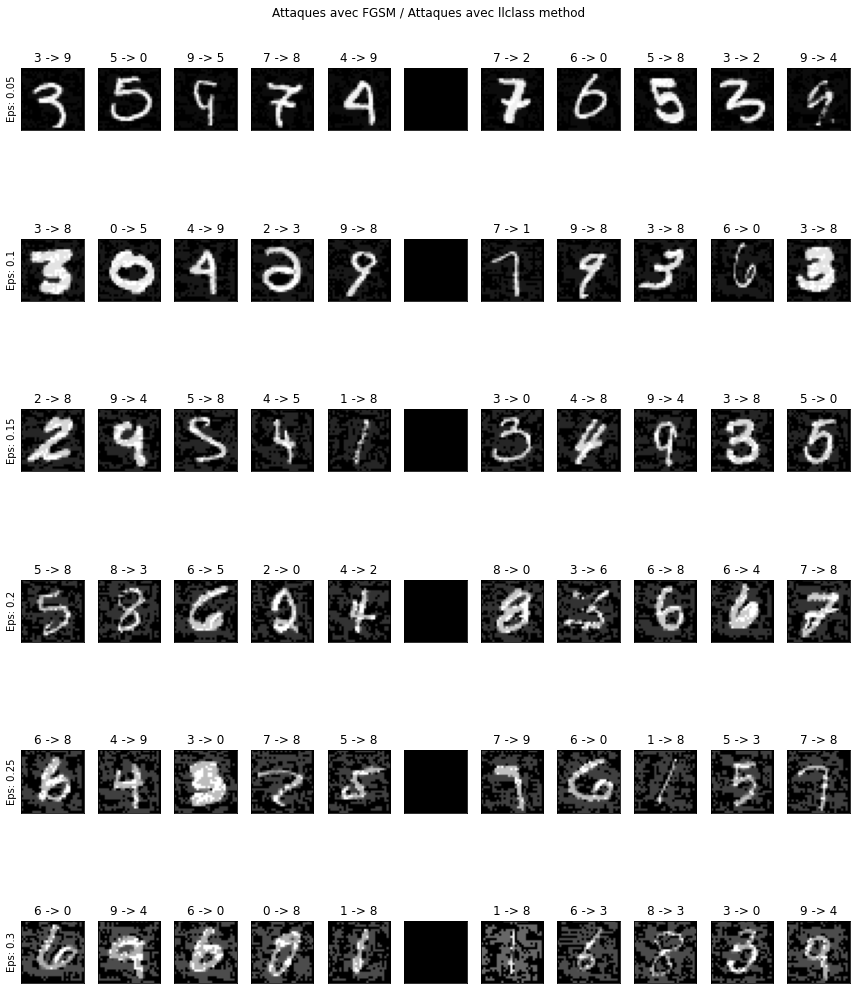

In [27]:
# Visualistion des attaques
cnt = 0
plt.figure(figsize=(12,15))
for eps in epsilons:
    for j in range(len(examples_fgsm[eps])+len(examples_llclass[eps])+1):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_fgsm[eps])+len(examples_llclass[eps])+1,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(eps, fontsize=14))
        if j==len(examples_fgsm[eps]):
            adv_image=np.zeros((28,28))
        elif j>len(examples_fgsm[eps]):
            orig_pred, adv_pred, adv_image = examples_llclass[eps][j-len(examples_fgsm[eps])-1]
            plt.title("{} -> {}".format(orig_pred, adv_pred))
        else :
            orig_pred, adv_pred, adv_image = examples_fgsm[eps][j]
            plt.title("{} -> {}".format(orig_pred, adv_pred))
        
        plt.imshow(adv_image, cmap="gray")
plt.suptitle('Attaques avec FGSM / Attaques avec llclass method')
plt.tight_layout()
plt.show()